In [12]:
import pandas as pd
import numpy as np

In [26]:
def format_stars(stars):
    stars = stars.split(', \'')
    stars = [star for star in stars if star != '' and star != '    Stars:\'']
    stars[0] = stars[0][2:]
    stars[-1] = stars[-1][:-2]

    dir_index = -1
    for j in range(len(stars)):
        stars[j] = stars[j].replace(', "', '')
        if ':\'' in stars[j]:
            stars[j] = stars[j].split(':\'')[1]
        
        if '|' in stars[j]:
            dir_index = j
    
    stars = stars[dir_index + 1:]

    return stars if stars != [] else None

def format_genres(genre):
    genres = genre.split(', ')
    return genres if genres != [] else None

def format_years(year):
    if len(year) < 5 or year[1] not in ['1', '2']:
        return None
    return int(year[1:5])

def format_votes(votes):
    if (type(votes) == str):
        votes = votes.replace(",", "")
        votes = float(votes)
    return votes

def set_is_tv(duration):
    duration = int(duration[0: -4])

    if duration < 70:
        return True
    return False

def get_cleaned_dataframe():
    df = pd.read_csv('./n_movies.csv')
    df = df.drop(columns=['description', 'certificate'])
    df = df.dropna(subset=['stars', 'duration', 'year', 'genre'])
    df = df.drop_duplicates(subset=['title'])

    df['stars'] = df['stars'].apply(format_stars)
    df['genre'] = df['genre'].apply(format_genres)
    df['year'] = df['year'].apply(format_years)
    df['is_tv'] = df['duration'].apply(set_is_tv)
    df['votes'] = df['votes'].apply(format_votes)
    
    df = df.dropna()
    df = df.reset_index()
    
    return df


In [42]:
df = get_cleaned_dataframe()

def get_top_media(df, n):
    # Creating dataframes of the top 500 rows sorted by number of votes
    top_media = media.sort_values(by='votes', ascending=False).iloc[:n]
    top_actors = []
    for _, row in top_media.iterrows():
        for star in row['stars']:
            if star not in top_actors:
                top_actors.append(star)
    return top_media

def get_unique_actors(df):
    actors = []
    for _, row in df.iterrows():
        for star in row['stars']:
            if star not in actors:
                actors.append(star)

    return actors


# Making seperate dataframes for movies, tv shows, and combined
movies = df.where(df['is_tv'] == False).dropna().reset_index(drop=True)
tv_shows = df.where(df['is_tv'] == True).dropna().reset_index(drop=True)
media = df.dropna().reset_index(drop=True)


# Creating lists of the actors found in the top 500 movies/tv shows/combined media
tv_top = get_top_media(tv_shows, 500)
tv_actors = get_unique_actors(tv_top)

movie_top = get_top_media(movies, 500)
movie_actors = get_unique_actors(movie_top)

media_top = get_top_media(media, 500)
media_actors = get_unique_actors(media_top)

all_actors = get_unique_actors(df)

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyvis.network import Network

# Network Visualization of Media with shared actors
def create_media_network(df, network, num_nodes):

    # Creating Nodes
    for i in tqdm(range(num_nodes)):
        network.add_node(df.loc[i,'title'])

    # Creating Edges
    for i in tqdm(range(num_nodes)):
        for j in range(i + 1, num_nodes):
            w = 0
            for actor in df.loc[i, 'stars']:
                if actor in df.loc[j, 'stars']:
                    if w == 0:
                        w += 2
                    else:
                        w += 5
            if w > 0:
                network.add_edge(df.loc[i, 'title'], df.loc[j, 'title'], weight=w,)
    return network

# Creating the networks
movie_network = nx.MultiGraph()
tv_show_network = nx.MultiGraph()
combine_network = nx.MultiGraph()

movie_network = create_media_network(movies, movie_network, 200)
tv_show_network = create_media_network(tv_shows, tv_show_network, 200)
combine_network = create_media_network(media, combine_network, 200)

# Scaling the nodes based on their degree
scale=4
d_movie = dict(movie_network.degree)
d_movie.update((x, scale*y) for x, y in d_movie.items())
d_tv_show = dict(tv_show_network.degree)
d_tv_show.update((x, scale*y) for x, y in d_tv_show.items())
d_combine = dict(combine_network.degree)
d_combine.update((x, scale*y) for x, y in d_combine.items())

# Setting up size attribute
nx.set_node_attributes(movie_network, d_movie,'size')
nx.set_node_attributes(tv_show_network, d_tv_show,'size')
nx.set_node_attributes(combine_network, d_combine,'size')

# Creating the Pyvis Networks
nt_movie = Network("500px", "500px")
nt_tv_show = Network("800px", "800px")
nt_combine = Network("800px", "800px")

nt_movie.from_nx(movie_network)
nt_tv_show.from_nx(tv_show_network)
nt_combine.from_nx(combine_network)

nt_movie.show("nx_movie.html", notebook=False)
nt_tv_show.show("nx_tv_show.html", notebook=False)
nt_combine.show("nx_combine.html", notebook=False)

100%|██████████| 200/200 [00:02<00:00, 90.28it/s] 


nx_movie.html
nx_tv_show.html
nx_combine.html


In [16]:
# Media Visualization of Actors with Shared Media

def create_actor_network(actors, df, network, num_nodes):
    # Creating Nodes
    for actor in range(num_nodes):
        network.add_node(actors[actor])

    # Creating Edges
    for i in range(num_nodes):
        for j in tqdm(range(len(df))):
            if actors[i] in df.loc[j, 'stars']:
                for actor_2 in df.loc[j, 'stars']:
                    print('hello')
                    if (actor_2 is not actors[i]) and (actor_2 in actors):
                        w=1
                        if (network.has_edge(actors[i], actor_2):
                            w += network
                        else:
                            network.add_edge(actors[i], actor_2)
    return network

movie_actor_network = nx.MultiGraph()
movie_actor_network = create_actor_network(movie_actors, movies, movie_actor_network, len(movie_actors))

# Scaling the nodes based on their degree
scale=4
d_actor = dict(network.degree)
d_actor.update((x, scale*y) for x, y in d_actor.items())

# Setting up size attribute
nx.set_node_attributes(network, d_actor,'size')

nt_actor = Network("500px", "500px")
nt_actor.from_nx(network)
nt_actor.show_buttons(filter_='physics')
nt_actor.show("nx_actor.html")

SyntaxError: invalid syntax (2320518961.py, line 16)

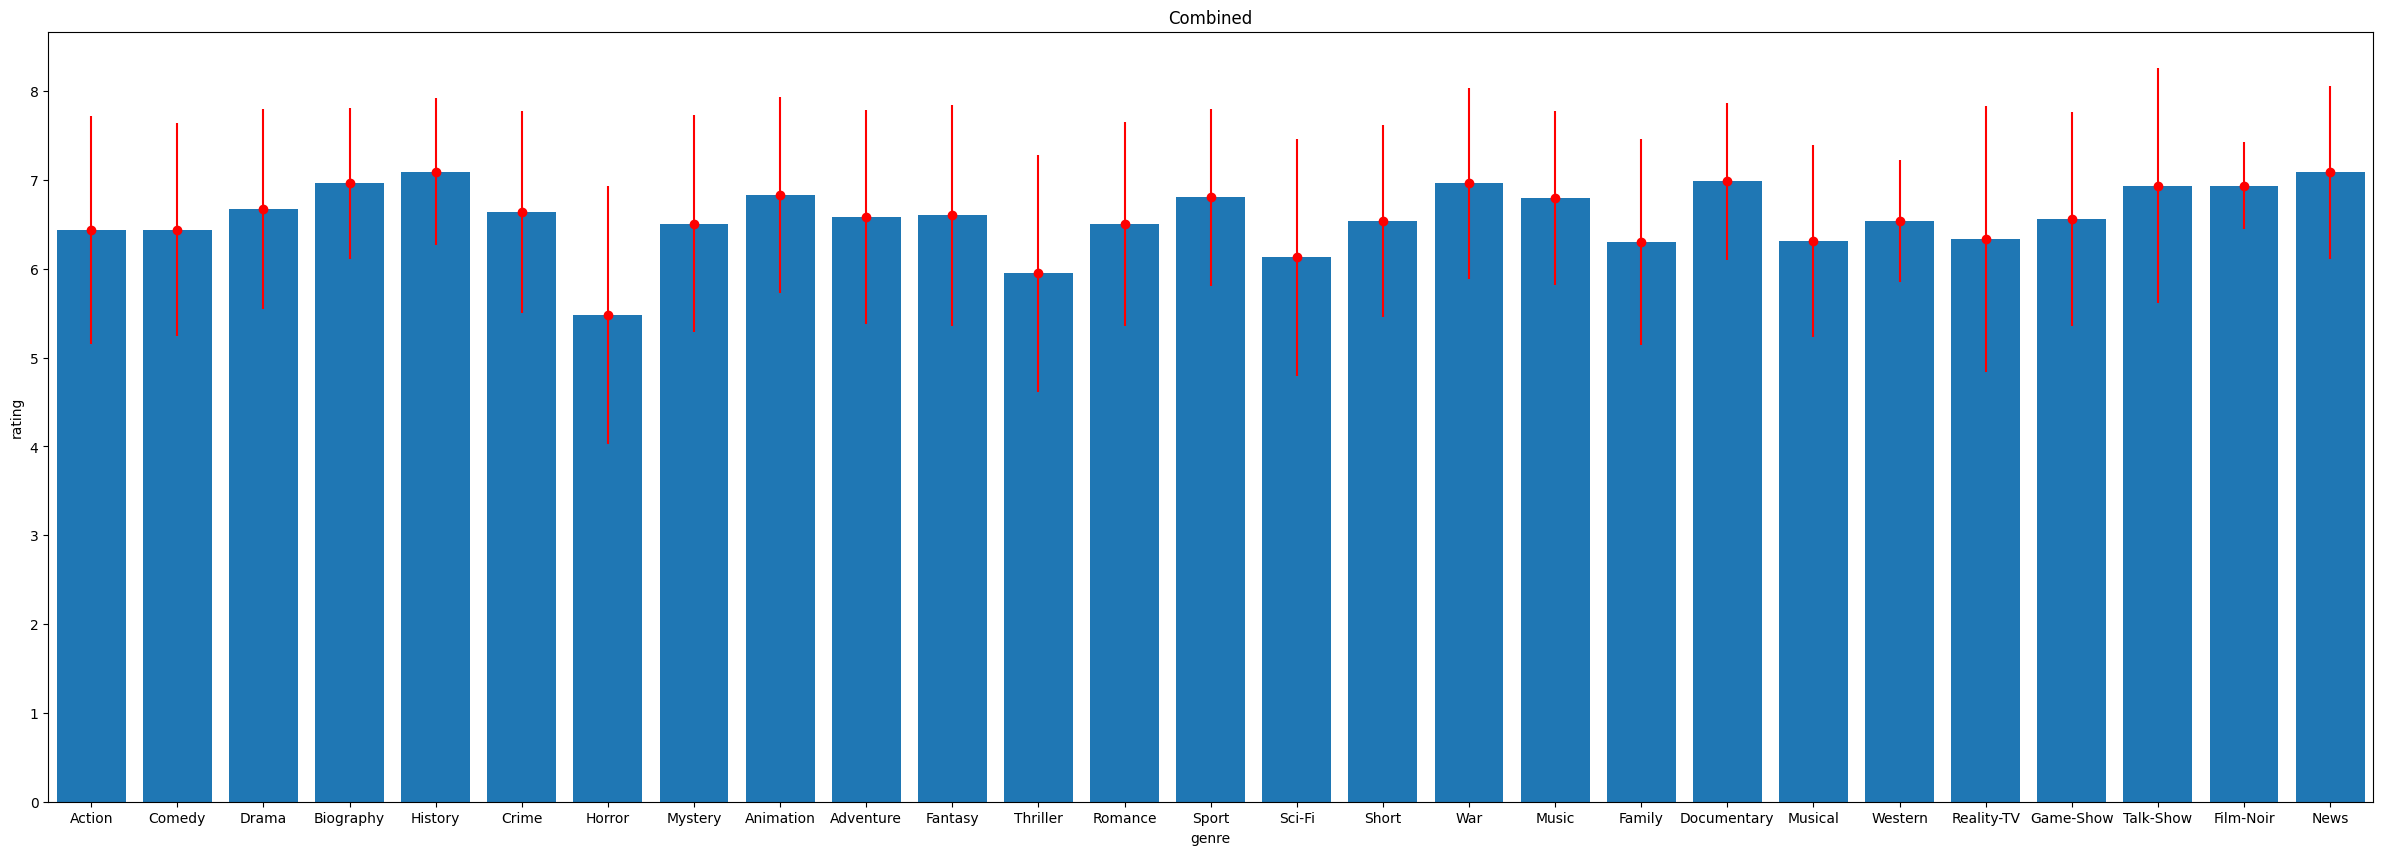

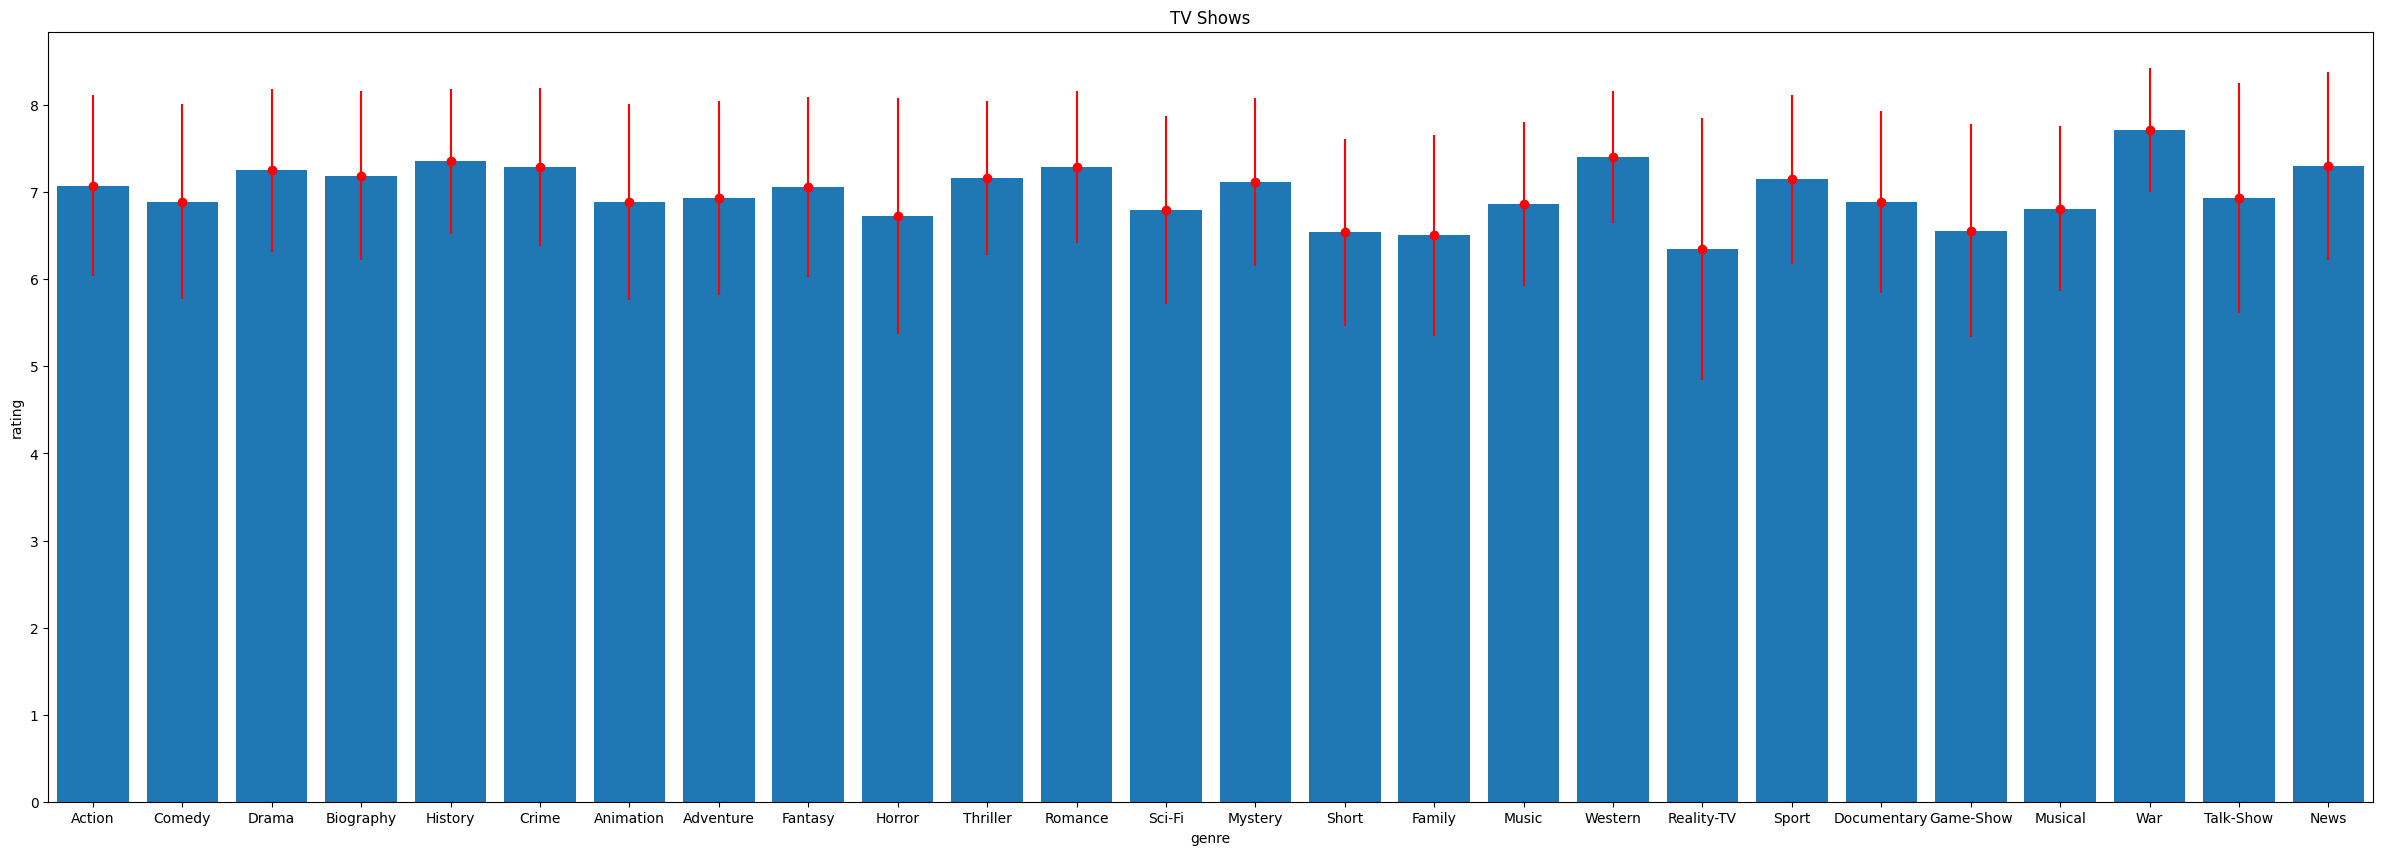

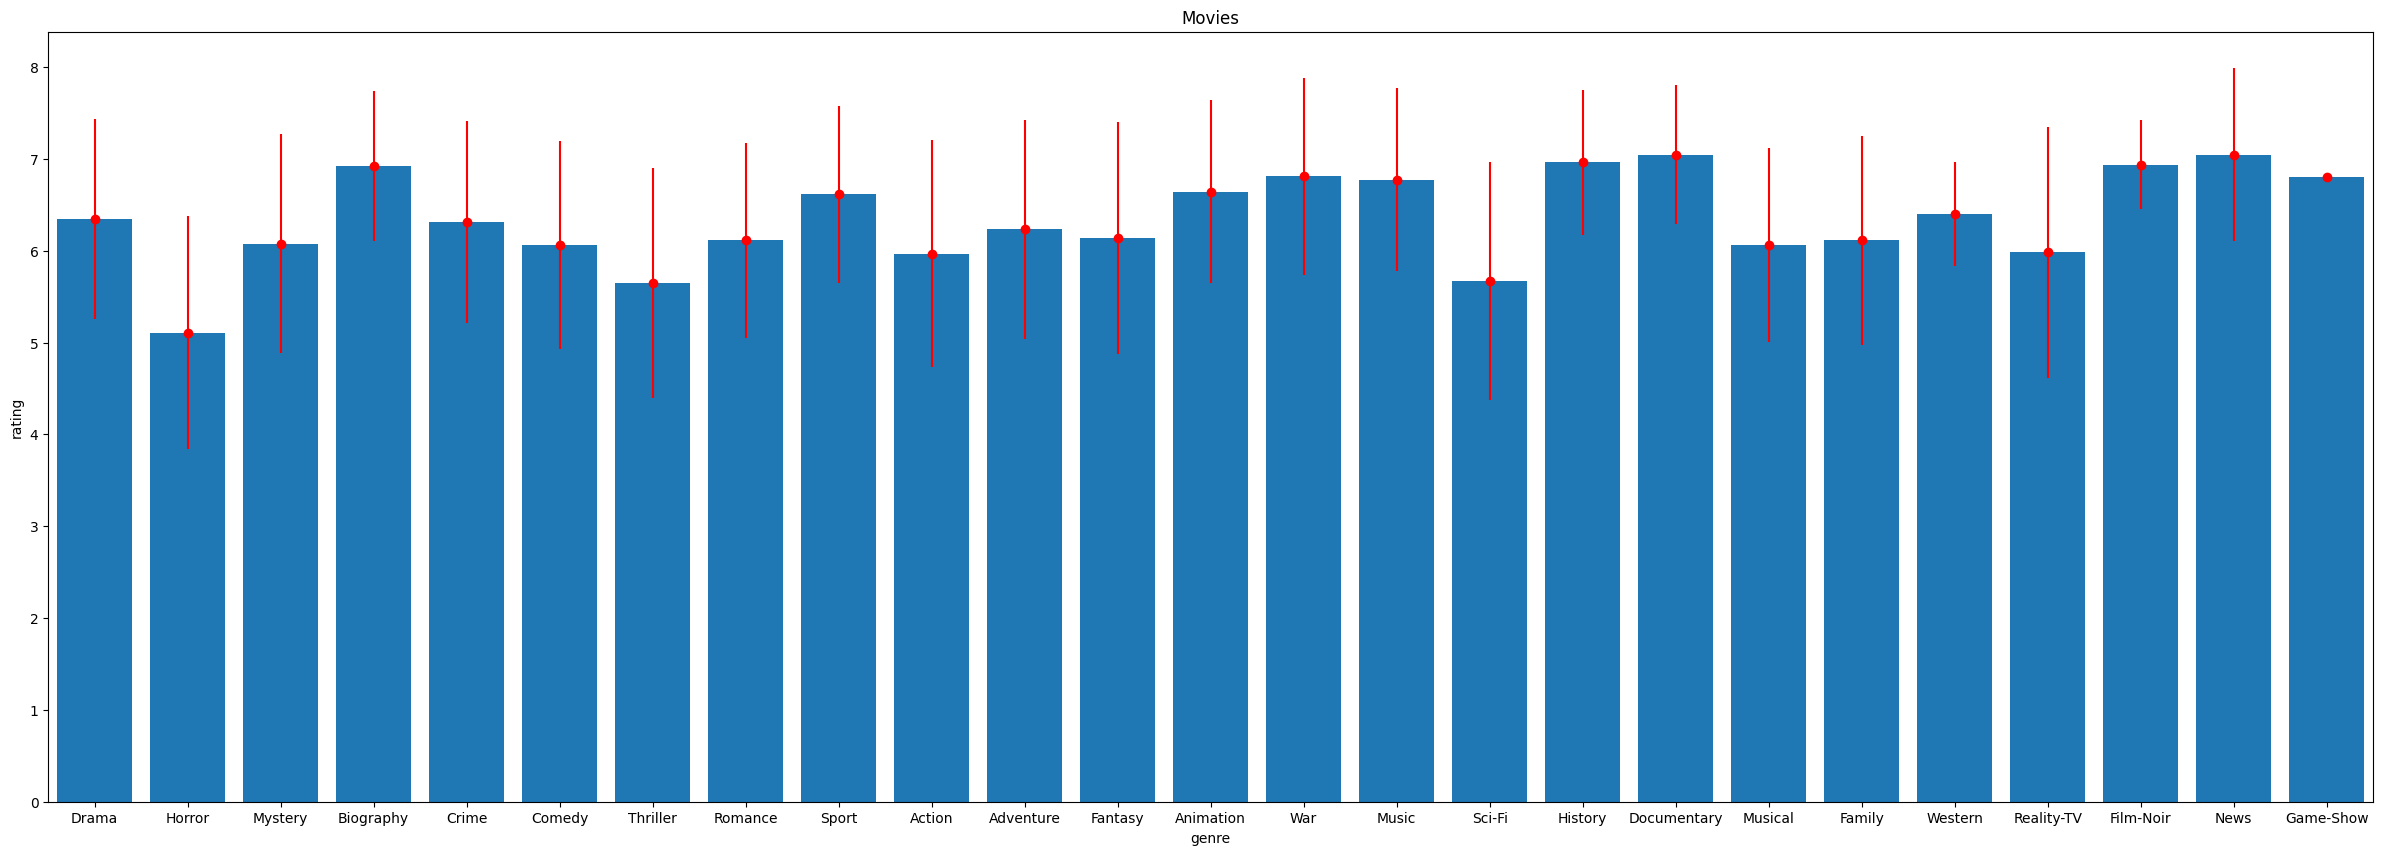

In [28]:
def plot_genre_v_rating(df, title):
    genre_ratings_dict = {}

    for _, row in df.iterrows():
        for genre in row['genre']:
            if genre not in genre_ratings_dict:
                genre_ratings_dict[genre] = []
            genre_ratings_dict[genre].append(row['rating'])

    genre_df = pd.DataFrame()

    for genre in genre_ratings_dict:
        ratings = genre_ratings_dict[genre]

        genre_df.loc[genre, 'mean'] = np.mean(ratings)
        genre_df.loc[genre, 'std'] = np.std(ratings)
        genre_df.loc[genre, 'count'] = len(ratings)


    plt.figure(figsize=(30, 10))
    plt.bar(x=genre_df.index, height=genre_df['mean'])
    plt.errorbar(range(len(genre_df)), genre_df['mean'], yerr=genre_df['std'], fmt='or')
    plt.xlim(-0.5,len(genre_df)-.5)
    plt.title(title)
    plt.xlabel('genre')
    plt.ylabel('rating')
    plt.show()

    return genre_df

combined_genre_df = plot_genre_v_rating(df, 'Combined')
tv_genre_df = plot_genre_v_rating(df.drop(df.loc[df['is_tv'] != True].index), 'TV Shows')
movie_genre_df = plot_genre_v_rating(df.drop(df.loc[df['is_tv'] != False].index), 'Movies')

In [49]:
actor_df = pd.DataFrame(index=all_actors, columns=combined_genre_df.index)

actor_df = actor_df.fillna(0)

for _, row in tqdm(df.iterrows()):
    for actor in row['stars']:
        if actor in row['stars']:
            for genre in row['genre']:
                actor_df.loc[actor, genre] += 1;

for genre in actor_df.columns:
    counts = [count for count in actor_df[genre] if count != 0] 
    print(f'Mean of {genre.lower()} movies for actors with at least 1: {np.mean(counts)}')
    print(f'Std dev of {genre.lower()} movies for actors with at least 1: {np.std(counts)}\n')
    

C:\Users\divad\AppData\Local\Temp\ipykernel_32300\4195852459.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  actor_df = actor_df.fillna(0)
5955it [00:10, 557.55it/s]


Mean of action movies for actors with at least 1: 1.2868074686256505
Std dev of action movies for actors with at least 1: 0.8842154581320569

Mean of comedy movies for actors with at least 1: 1.3039686777006585
Std dev of comedy movies for actors with at least 1: 3.7064087750701877

Mean of drama movies for actors with at least 1: 1.2407798336023843
Std dev of drama movies for actors with at least 1: 0.6372407206692758

Mean of biography movies for actors with at least 1: 1.056985294117647
Std dev of biography movies for actors with at least 1: 0.36439276614531074

Mean of history movies for actors with at least 1: 1.0277456647398844
Std dev of history movies for actors with at least 1: 0.22382410529534866

Mean of crime movies for actors with at least 1: 1.1336070751737208
Std dev of crime movies for actors with at least 1: 0.5782115146330975

Mean of horror movies for actors with at least 1: 1.0383224873463486
Std dev of horror movies for actors with at least 1: 0.20996316891258462

